--- Environment Check ---
PyTorch: 2.9.0+cu126
CUDA: True
GPU: Tesla T4
-------------------------

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.0 MB/s eta 0:00:00

STEP 0: UPLOAD AND EXTRACT FILES

1. Upload data.csv:


Saving data.csv to data.csv

2. Upload images.zip:


Saving images.zip to images.zip

Extracting images.zip...
✓ Using CSV: data.csv
✓ Using images from: temp_images_extract

STEP 1: DATA PREPARATION FOR YOLOv5
Loaded 4888 annotations
Classes: ['Platelets', 'RBC', 'WBC']

Class Distribution:
    Platelets: 361 (7.4%)
    RBC: 4155 (85.0%)
    WBC: 372 (7.6%)

Total images: 364
Train images: 291 (80%)
Validation images: 73 (20%)

Processing train split...


train: 100%|██████████| 291/291 [00:00<00:00, 323.07it/s]


Processed 291 images for train (Total boxes: 3848)

Processing val split...


val: 100%|██████████| 73/73 [00:00<00:00, 334.63it/s]

Processed 73 images for val (Total boxes: 1038)

Training set: 291 images, 3848 boxes
Validation set: 73 images, 1038 boxes

DATA PREPARATION COMPLETED!

STEP 2: TRAINING YOLOv5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Training on: cuda
Loading yolov5su.pt model...

Training configuration:
    Epochs: 60
    Batch size: 16
    Image size: 640
    Device: cuda
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolov5_data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.75, hsv_v=0.45, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5_blo

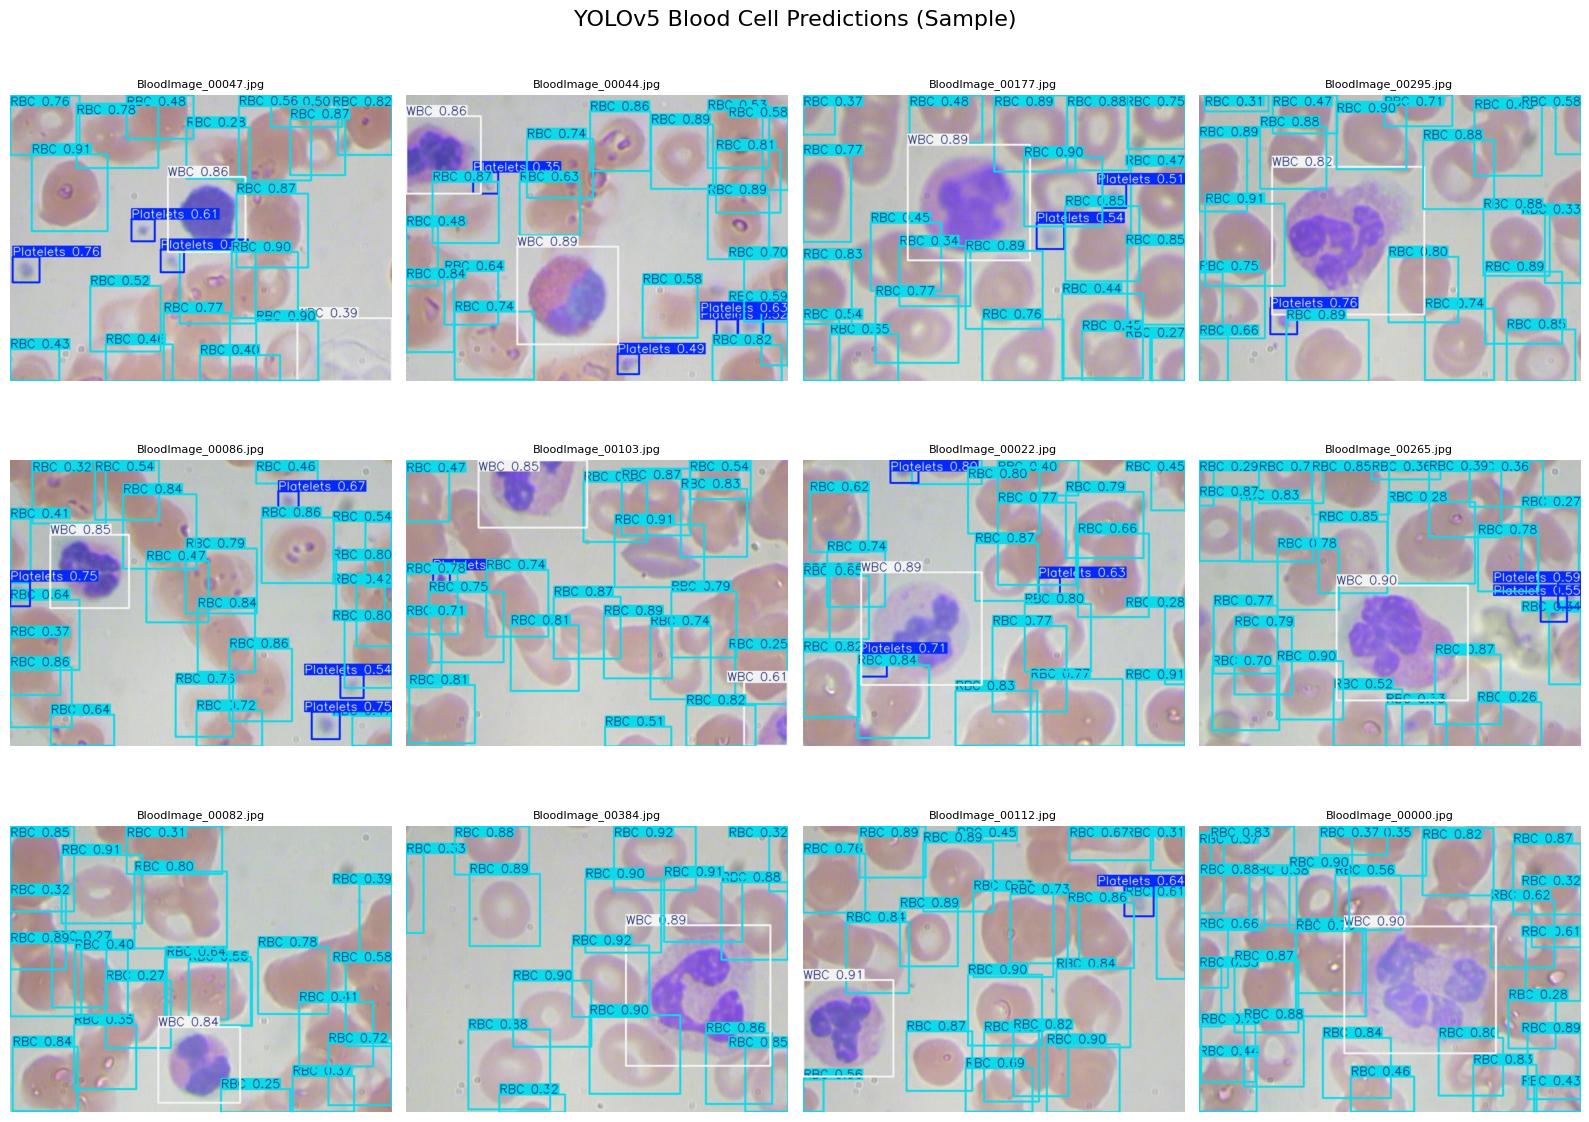

Saved visualization as 'yolov5_predictions_viz.png'

YOLOv5 TRAINING COMPLETED!

Results:
    Training time: 6.65 minutes
    Device used: GPU
    mAP@0.5: 0.9354
    mAP@0.5:0.95: 0.6458

 Files created:
    - Training results: runs/detect/yolov5_blood_cell_v2/
    - Best model: runs/detect/yolov5_blood_cell_v2/weights/best.pt
    - Predictions: runs/detect/yolov5_predictions_final/
    - Visualization: yolov5_predictions_viz.png
    - Dataset config: yolov5_data.yaml

TRAINING CURVES (results.png)


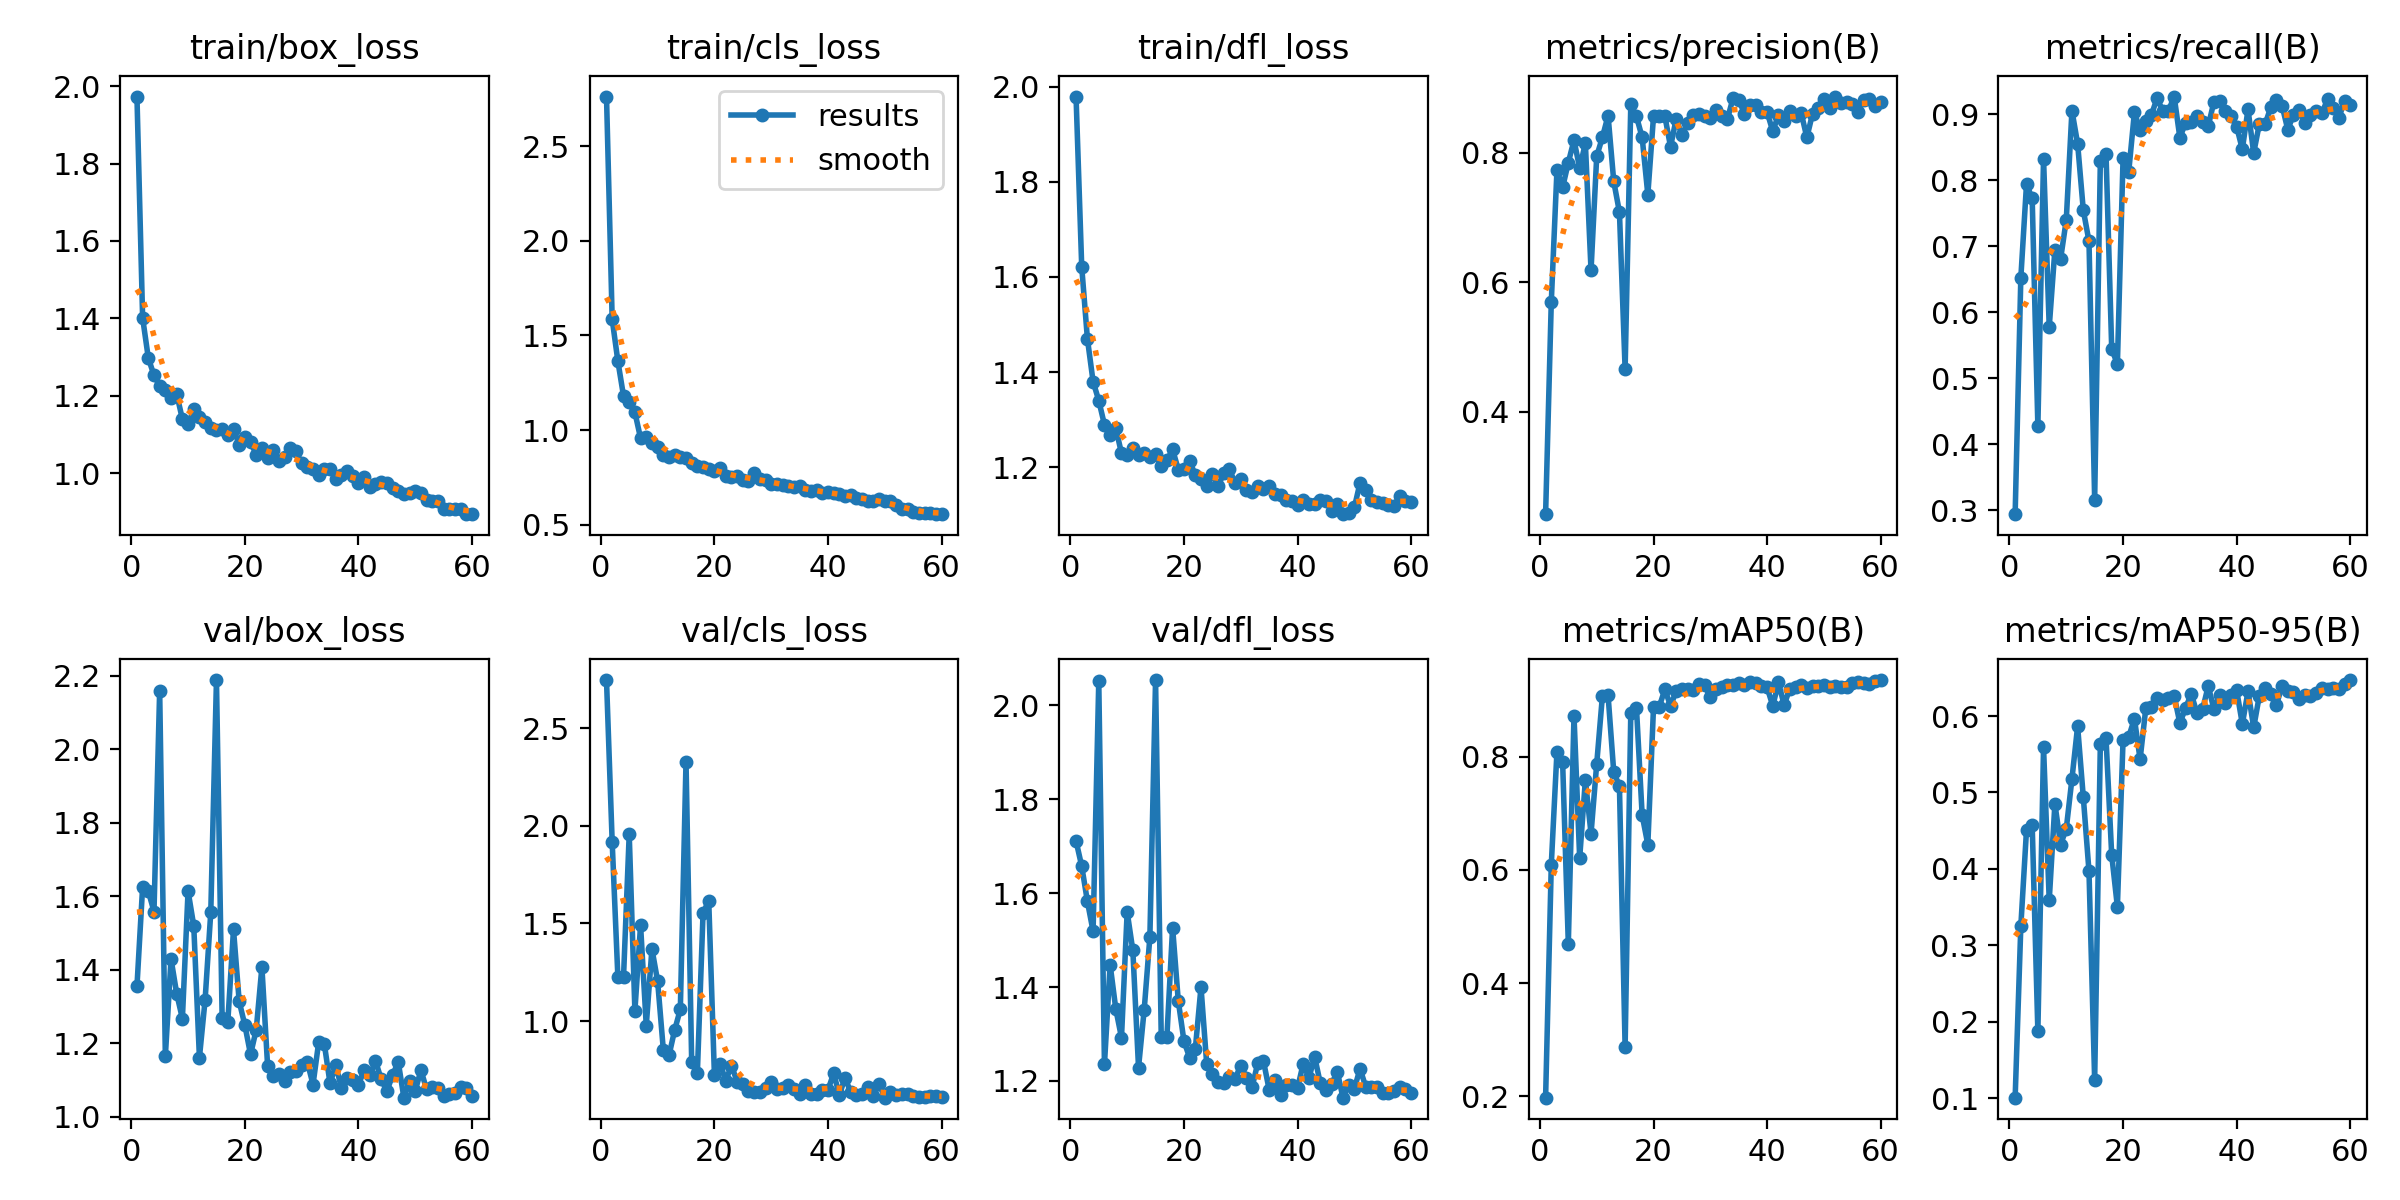


CONFUSION MATRIX:


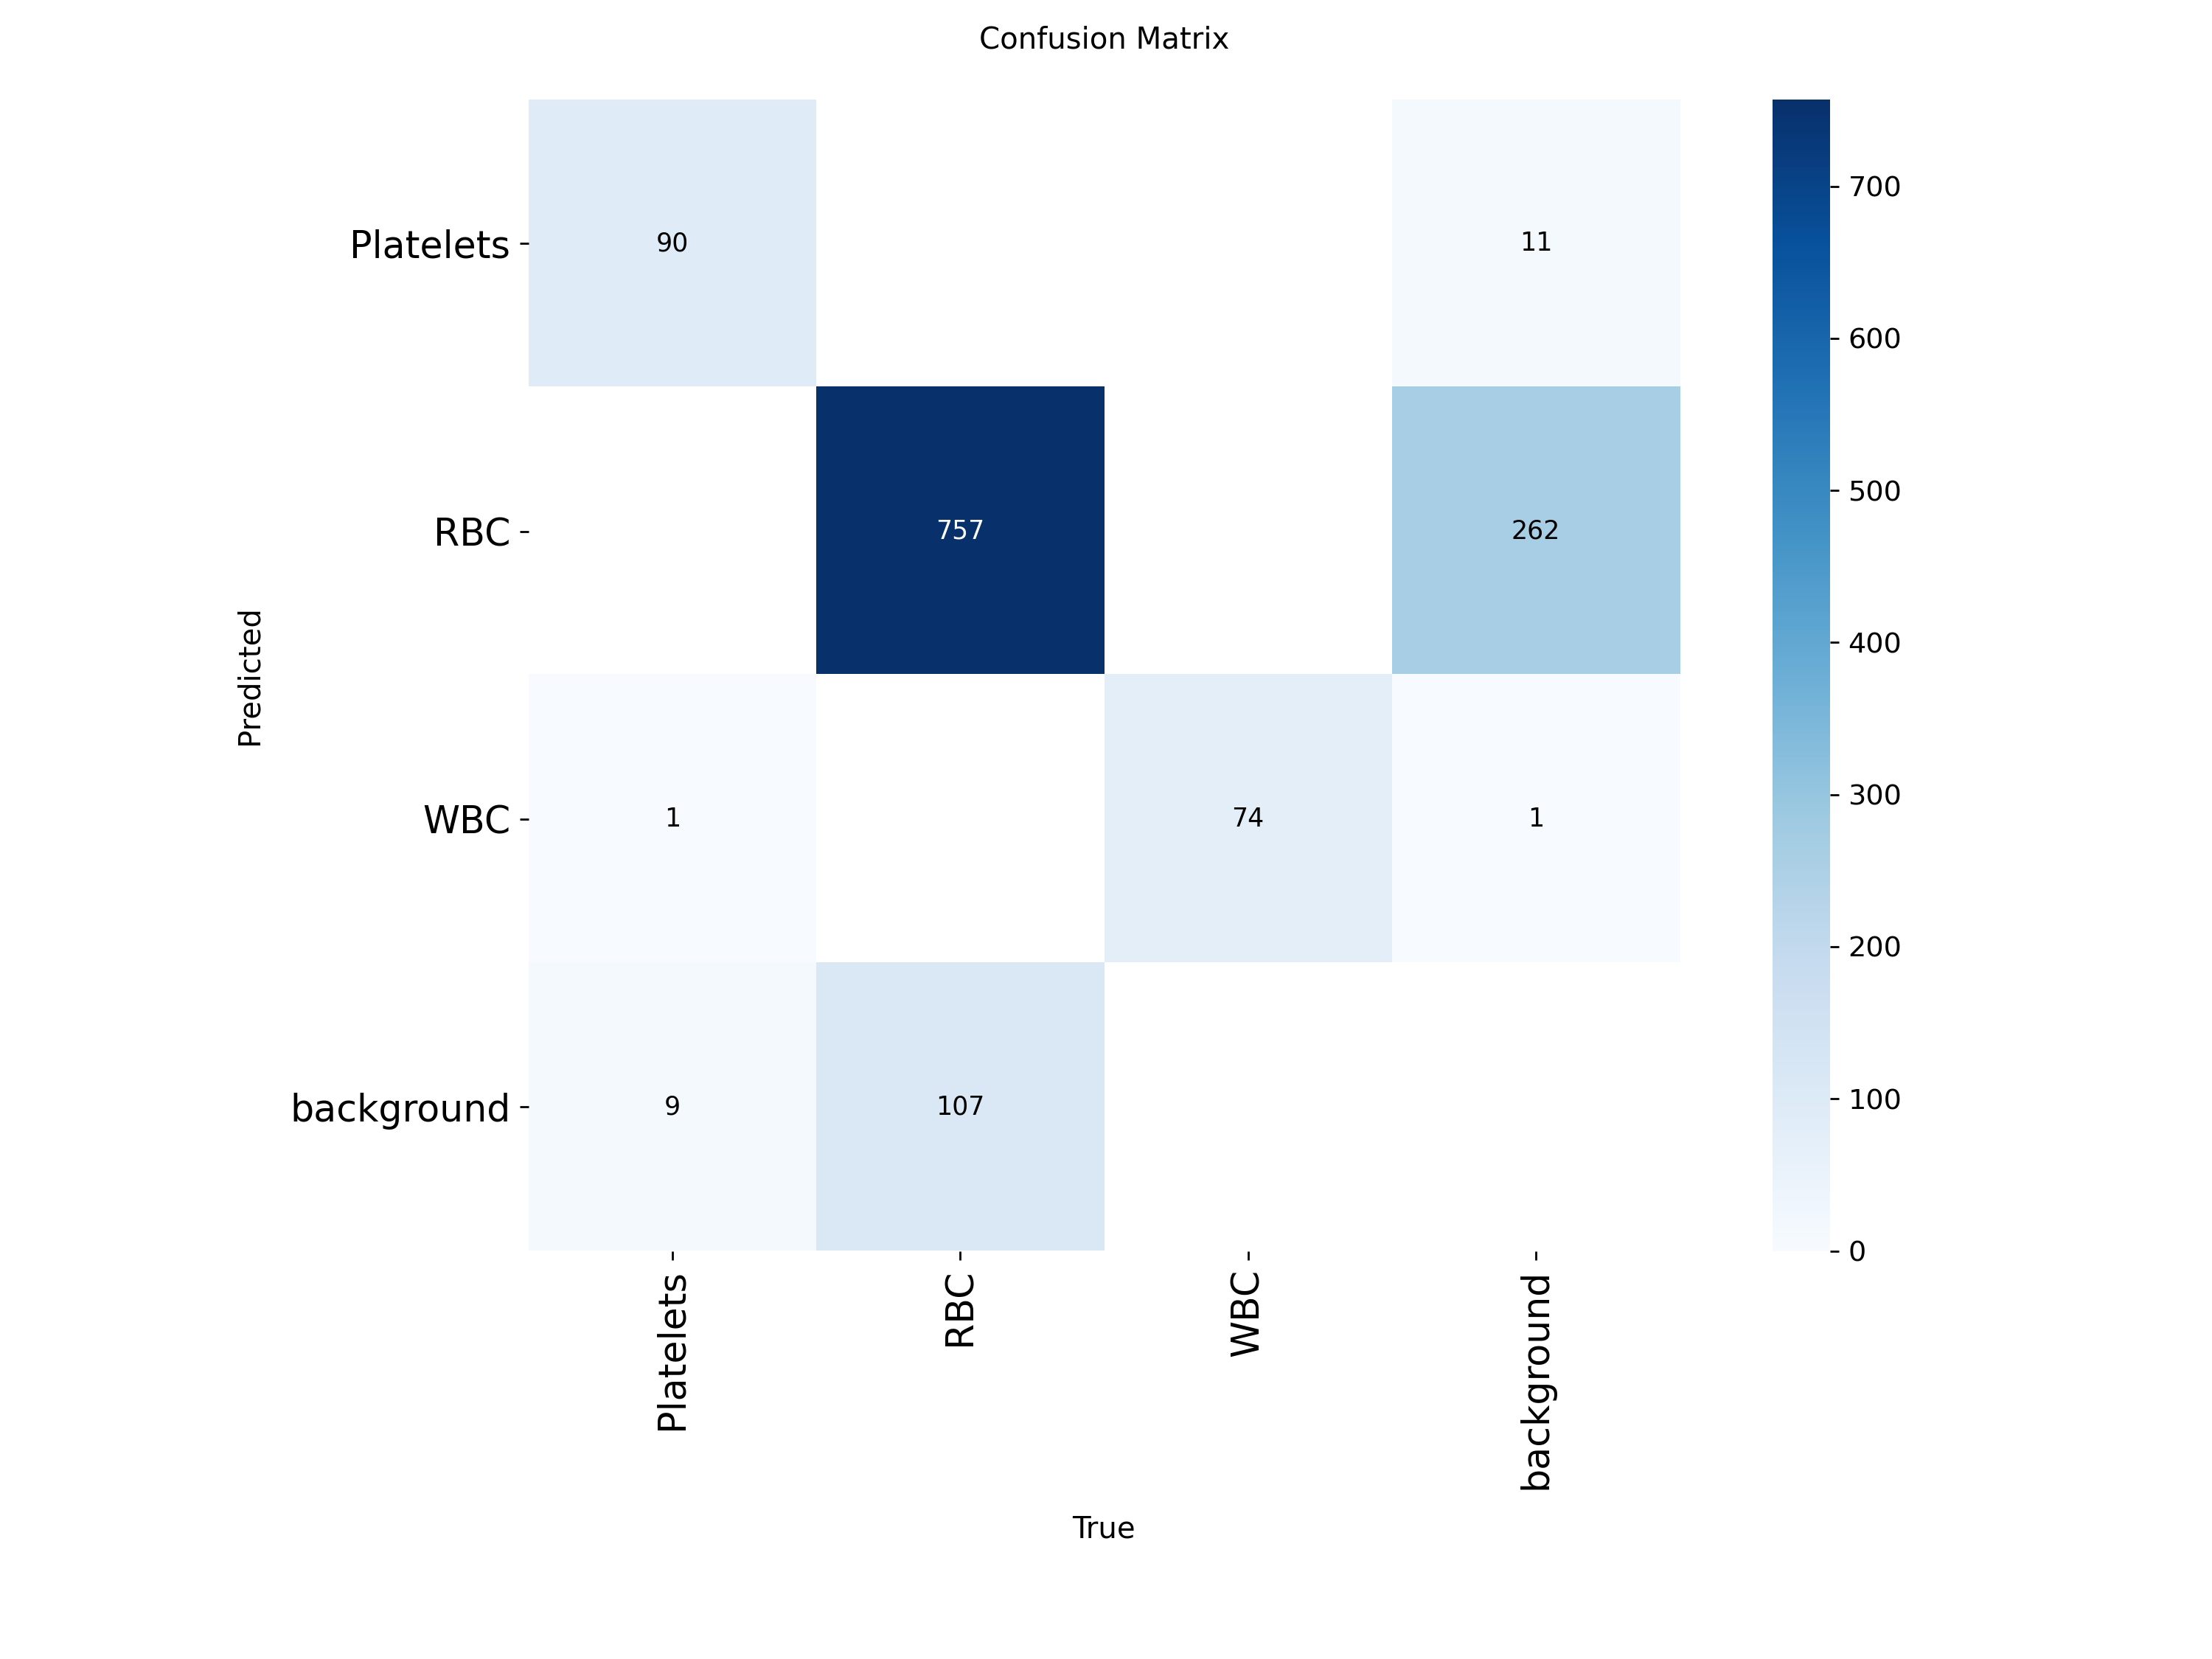


COMPLETE!


In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import cv2
import yaml
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import warnings
import zipfile
from google.colab import files
warnings.filterwarnings('ignore')
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
set_seed(42)
print("--- Environment Check ---")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("-------------------------")

print("\nInstalling required packages...")
!pip install -q ultralytics opencv-python pandas matplotlib pyyaml

print("\n" + "="*70)
print("STEP 0: UPLOAD AND EXTRACT FILES")
print("="*70)

try:

    print("\n1. Upload data.csv:")
    uploaded_csv = files.upload()
    csv_filename = list(uploaded_csv.keys())[0]
    print("\n2. Upload images.zip:")
    uploaded_zip = files.upload()
    zip_filename = list(uploaded_zip.keys())[0]

except IndexError:
    print("\nERROR: File upload failed or was cancelled. Please upload both files.")
    exit()
print(f"\nExtracting {zip_filename}...")
extraction_dir = 'temp_images_extract'
os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)
images_folder = extraction_dir
subfolders = [f for f in os.listdir(extraction_dir) if os.path.isdir(os.path.join(extraction_dir, f))]

if len(subfolders) == 1:
    images_folder = os.path.join(extraction_dir, subfolders[0])


if images_folder != extraction_dir:
    for f in os.listdir(extraction_dir):
        if not os.path.isdir(os.path.join(extraction_dir, f)):
            os.remove(os.path.join(extraction_dir, f))

if not any(f.lower().endswith(('.jpg', '.png', '.jpeg')) for f in os.listdir(images_folder)):
    print(f"Warning: No images found in '{images_folder}'. Reverting to root extraction directory.")
    images_folder = extraction_dir

print(f"✓ Using CSV: {csv_filename}")
print(f"✓ Using images from: {images_folder}")


def prepare_dataset_for_yolov5(csv_path, images_folder):
    print("\n" + "=" * 70)
    print("STEP 1: DATA PREPARATION FOR YOLOv5")
    print("=" * 70)

    df = pd.read_csv(csv_path, header=None,
                     names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])

    df['filename'] = df['filename'].apply(os.path.basename)
    print(f"Loaded {len(df)} annotations")

    classes = sorted(df['class'].unique())
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    print(f"Classes: {classes}")

    print("\nClass Distribution:")
    for cls in classes:
        count = len(df[df['class'] == cls])
        percentage = count / len(df) * 100
        print(f"    {cls}: {count} ({percentage:.1f}%)")

    unique_images = df['filename'].unique()
    print(f"\nTotal images: {len(unique_images)}")

    train_images, val_images = train_test_split(
        unique_images, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"Train images: {len(train_images)} (80%)")
    print(f"Validation images: {len(val_images)} (20%)")

    os.makedirs('yolov5_dataset/images/train', exist_ok=True)
    os.makedirs('yolov5_dataset/images/val', exist_ok=True)
    os.makedirs('yolov5_dataset/labels/train', exist_ok=True)
    os.makedirs('yolov5_dataset/labels/val', exist_ok=True)

    total_boxes_train = 0
    total_boxes_val = 0

    for split_name, image_list in [('train', train_images), ('val', val_images)]:
        print(f"\nProcessing {split_name} split...")

        processed = 0
        total_boxes = 0
        for img_name in tqdm(image_list, desc=f"{split_name}"):


            img_path = os.path.join(images_folder, img_name)

            if not os.path.exists(img_path):

                found = False
                for ext in ['', '.jpg', '.jpeg', '.png']:
                    test_path = os.path.join(images_folder, os.path.splitext(img_name)[0] + ext)
                    if os.path.exists(test_path):
                        img_path = test_path
                        found = True
                        break
                if not found:
                    continue

            shutil.copy(img_path, f'yolov5_dataset/images/{split_name}/')

            img = cv2.imread(img_path)
            if img is None:
                continue

            h, w = img.shape[:2]

            img_annots = df[df['filename'] == img_name]

            label_file = f'yolov5_dataset/labels/{split_name}/{os.path.splitext(img_name)[0]}.txt'
            boxes_in_image = 0
            with open(label_file, 'w') as f:
                for _, row in img_annots.iterrows():
                    # Calculate YOLO format
                    x_center = ((row['xmin'] + row['xmax']) / 2) / w
                    y_center = ((row['ymin'] + row['ymax']) / 2) / h
                    width = (row['xmax'] - row['xmin']) / w
                    height = (row['ymax'] - row['ymin']) / h


                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    width = max(0, min(1, width))
                    height = max(0, min(1, height))

                    if width <= 0 or height <= 0:
                        continue

                    class_id = class_to_idx[row['class']]
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                    boxes_in_image += 1

            if boxes_in_image > 0:
                processed += 1
                total_boxes += boxes_in_image

        print(f"Processed {processed} images for {split_name} (Total boxes: {total_boxes})")
        if split_name == 'train':
            total_boxes_train = total_boxes
        else:
            total_boxes_val = total_boxes


    yaml_content = {
        'path': os.path.abspath('yolov5_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(classes),
        'names': classes
    }

    with open('yolov5_data.yaml', 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

    print(f"\nTraining set: {len(train_images)} images, {total_boxes_train} boxes")
    print(f"Validation set: {len(val_images)} images, {total_boxes_val} boxes")
    print("\n" + "=" * 70)
    print("DATA PREPARATION COMPLETED!")
    print("=" * 70 + "\n")

    return classes


def train_yolov5():
    print("=" * 70)
    print("STEP 2: TRAINING YOLOv5")
    print("=" * 70)

    from ultralytics import YOLO

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Training on: {device}")

    model_name = 'yolov5su.pt'
    print(f"Loading {model_name} model...")
    model = YOLO(model_name)

    batch_size = 16 if device == 'cuda' else 8

    print(f"\nTraining configuration:")
    print(f"    Epochs: 60")
    print(f"    Batch size: {batch_size}")
    print(f"    Image size: 640")
    print(f"    Device: {device}")

    start_time = time.time()

    results = model.train(
        data='yolov5_data.yaml',
        epochs=60,
        imgsz=640,
        batch=batch_size,
        device=0 if device == 'cuda' else 'cpu',
        name='yolov5_blood_cell_v2',
        patience=15,
        save=True,
        plots=True,
        verbose=False,
        optimizer='SGD',
        lr0=0.01,
        lrf=0.01,
        momentum=0.937,
        weight_decay=0.0005,
        hsv_h=0.02, hsv_s=0.75, hsv_v=0.45,
        degrees=10, translate=0.15, scale=0.6, shear=3.0, fliplr=0.5, mosaic=1.0,
        exist_ok=True
    )

    training_time = time.time() - start_time

    print(f"\n" + "=" * 70)
    print(f"Training completed in {training_time/60:.2f} minutes")
    print("=" * 70 + "\n")

    return training_time, model


def evaluate_yolov5(model):
    print("=" * 70)
    print("STEP 3: MODEL EVALUATION")
    print("=" * 70)

    print("Running validation...")
    metrics = model.val(data='yolov5_data.yaml')

    print(f"\n" + "=" * 70)
    print("PERFORMANCE METRICS")
    print("=" * 70)
    print(f"\nOverall Metrics:")
    print(f"    Precision:       {metrics.box.mp:.4f}")
    print(f"    Recall:          {metrics.box.mr:.4f}")
    print(f"    mAP@0.5:         {metrics.box.map50:.4f}")
    print(f"    mAP@0.5:0.95:    {metrics.box.map:.4f}")

    try:
        with open('yolov5_data.yaml', 'r') as f:
            data_config = yaml.safe_load(f)
            classes = data_config.get('names', [])

        if hasattr(metrics.box, 'ap_class_index'):
            print(f"\nPer-Class Metrics:")
            for i, class_idx in enumerate(metrics.box.ap_class_index):
                if i < len(classes):
                    class_name = classes[class_idx]
                    print(f"  {class_name}:")
                    print(f"      Precision:     {metrics.box.p[i]:.4f}")
                    print(f"      Recall:        {metrics.box.r[i]:.4f}")
                    print(f"      mAP@0.5:       {metrics.box.ap50[i]:.4f}")
                    print(f"      mAP@0.5:0.95:  {metrics.box.ap[i]:.4f}")
    except Exception:
        pass

    print(f"\n" + "=" * 70 + "\n")

    return metrics


def generate_predictions(model):
    print("=" * 70)
    print("STEP 4: GENERATING PREDICTIONS")
    print("=" * 70)

    print("Running inference on validation images...")

    results = model.predict(
        source='yolov5_dataset/images/val',
        conf=0.25,
        save=True,
        save_txt=True,
        save_conf=True,
        project='runs/detect',
        name='yolov5_predictions_final',
        exist_ok=True
    )

    print(f"Predictions saved to runs/detect/yolov5_predictions_final/")
    print("=" * 70 + "\n")


def visualize_predictions():
    print("Generating visualization of sample predictions...")

    pred_folder = 'runs/detect/yolov5_predictions_final'
    if not os.path.exists(pred_folder):
        print("Prediction folder not found!")
        return

    # Filter for image files
    pred_images = []
    for f in os.listdir(pred_folder):
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            pred_images.append(f)

    pred_images = pred_images[:12]

    if not pred_images:
        print("No prediction images found!")
        return

    cols = 4
    rows = (len(pred_images) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))

    if rows * cols > 1:
        axes = axes.ravel()
    else:
        axes = [axes]

    for idx, img_name in enumerate(pred_images):
        if idx >= len(axes):
            break

        img_path = os.path.join(pred_folder, img_name)
        img = cv2.imread(img_path)

        if img is not None:

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb)
            axes[idx].axis('off')
            axes[idx].set_title(img_name[:20], fontsize=8)


    for idx in range(len(pred_images), len(axes)):
        axes[idx].axis('off')

    plt.suptitle("YOLOv5 Blood Cell Predictions (Sample)", fontsize=16)
    plt.tight_layout()
    plt.savefig('yolov5_predictions_viz.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved visualization as 'yolov5_predictions_viz.png'")



def main():

    global csv_filename, images_folder

    classes = prepare_dataset_for_yolov5(csv_filename, images_folder)

    training_time, model = train_yolov5()


    metrics = evaluate_yolov5(model)

    generate_predictions(model)

    visualize_predictions()

    print("\n" + "=" * 70)
    print("YOLOv5 TRAINING COMPLETED!")
    print("=" * 70)
    print(f"\nResults:")
    print(f"    Training time: {training_time/60:.2f} minutes")
    print(f"    Device used: {'GPU' if torch.cuda.is_available() else 'CPU'}")
    print(f"    mAP@0.5: {metrics.box.map50:.4f}")
    print(f"    mAP@0.5:0.95: {metrics.box.map:.4f}")
    print(f"\n Files created:")
    print(f"    - Training results: runs/detect/yolov5_blood_cell_v2/")
    print(f"    - Best model: runs/detect/yolov5_blood_cell_v2/weights/best.pt")
    print(f"    - Predictions: runs/detect/yolov5_predictions_final/")
    print(f"    - Visualization: yolov5_predictions_viz.png")
    print(f"    - Dataset config: yolov5_data.yaml")
    print("=" * 70)


    from IPython.display import Image, display

    print("\n" + "=" * 70)
    print("TRAINING CURVES (results.png)")
    print("=" * 70)

    results_img = 'runs/detect/yolov5_blood_cell_v2/results.png'
    if os.path.exists(results_img):
        display(Image(filename=results_img, width=800))

    confusion_img = 'runs/detect/yolov5_blood_cell_v2/confusion_matrix.png'
    if os.path.exists(confusion_img):
        print("\nCONFUSION MATRIX:")
        display(Image(filename=confusion_img, width=600))

    shutil.rmtree(extraction_dir, ignore_errors=True)

    print("\nCOMPLETE!")


if __name__ == "__main__":
    main()
